# Find optimal edge detection for image stack

In [1]:
import cv2
import glob
from IPython.display import Video
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import sys
from ipywidgets import interactive, IntSlider, Layout, FloatText, IntText, RadioButtons
import os
%matplotlib inline

In [2]:
files = sorted(glob.glob('images/*.jpeg'))
h, w = 3024, 4032

In [3]:
len(files)

24

In [4]:
Z = np.zeros((h*6, w*2*4)).astype('uint8')

E = []

n = 0
for f in files:
    im = cv2.imread(f)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    e = cv2.Canny(gray, 60, 300)
    E.append(e)
    z = np.c_[gray, e].astype('uint8')
    
    i = n % 6
    j = n // 6
    
    Z[
        i*h   : (i+1)*h, 
        j*w*2 : (j+1)*w*2
    ] = z
    sys.stdout.write('\r%d' % n)
    
    n += 1

23

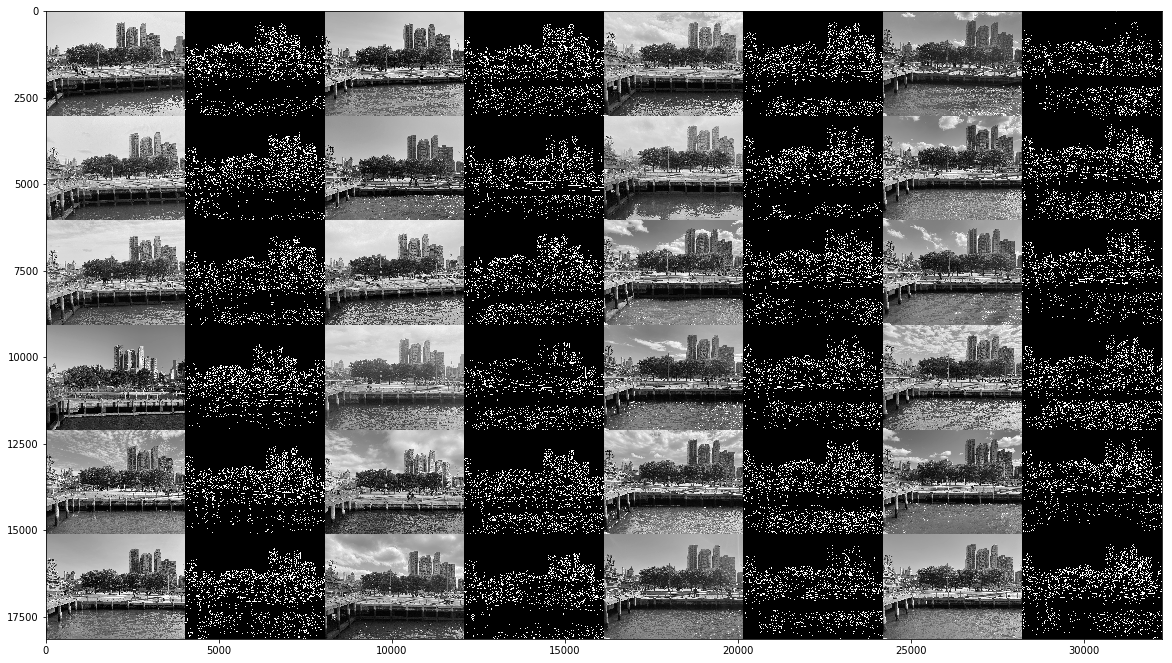

In [5]:
fig, ax = plt.subplots(figsize=(20, 30))
ax.imshow(Z, cmap='gray')
plt.show()

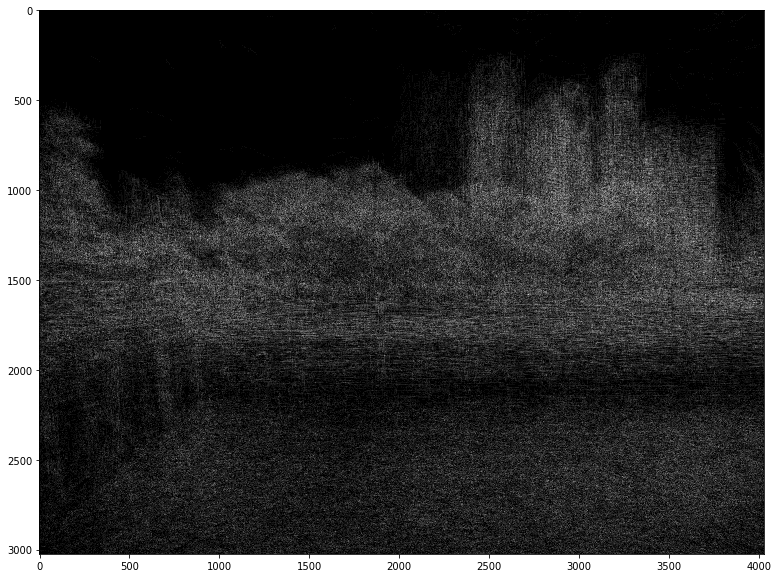

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(np.array(E).sum(0), cmap='gray')
plt.show()

In [45]:
z0 = E[-1]

def err(m, z0, z1, pad=100):
    m = m.reshape((2, 3))
    zW = cv2.warpAffine(z1, m, z0.T.shape)
    r = zW[pad:-pad, pad:-pad] - z0[pad:-pad, pad:-pad]
    return (r**2).sum()

# initial guess for affine transform
m0 = np.r_[1, 0, 0, 0, 1, 0].astype('float32')

warped = [z0]

#for n in range(2, 25):
for n in range(2, 4):
    sys.stdout.write('\r%d' % n)
    z1 = E[-n]

    # function call for lambda function
    f = lambda m: err(
        m,
        z0=z0.astype(float),
        z1=z1.astype(float)
    )

    # perform minimization
    r = minimize(
        f, m0, method='Powell'
    )
    # apply affine transform
    zW = cv2.warpAffine(z1, r.x.reshape((2, 3)), z1.T.shape)
    print(z1.sum(), zW.sum())
    warped.append(zW)

2254361225 0
3365225280 0


In [47]:
r

   direc: array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ],
       [13.55057209, 16.497133  ,  6.69737631,  6.69737631,  6.69737631,
         6.69737631]])
     fun: 73788419250.0
 message: 'Optimization terminated successfully.'
    nfev: 168
     nit: 2
  status: 0
 success: True
       x: array([57.44248702, 65.56518805, 29.20556835, 29.20556835, 30.20556835,
       29.20556835])